Please choose a graph-based GNN model of your choice to classify (quark/gluon) jets. Proceed as follows:

* Convert the images into a point cloud dataset by only considering the non-zero pixels for every event.

* Cast the point cloud data into a graph representation by coming up with suitable representations for nodes and edges.

* Train your model on the obtained graph representations of the jet events.

Discuss the resulting performance of the chosen architecture.


## Loading Quark-Gluon Data :

Loading the hdf5 file using `h5py`'s `File` object with the Standard Driver appropriate for the current platform.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import h5py

def load_h5(file_name, size):
    # Load the dataset from the HDF5 file
    with h5py.File(file_name, 'r') as f:
        X = np.array(f['X_jets'][:size])
        y = np.array(f['y'][:size])
    return X, y


In [3]:
file = '/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5'
size = 16000
X, y = load_h5(file, size)

In [4]:
# Count occurrences of each value (0s and 1s)
y_int = y.astype(np.int64)
counts = np.bincount(y_int)

# Create a dictionary to store counts
counts_dict = {'0': counts[0], '1': counts[1]}

print(counts_dict)
del y_int
del counts
del counts_dict

{'0': 7953, '1': 8047}


In [5]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.4 MB/s eta 0:00:00



Importing necessary libaries and modules as required for the immediate tasks ->

In [6]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch.optim import Adam
import torch.optim as optim
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_mean_pool
from torch.nn import Linear

In [8]:
from skimage.transform import resize
from sklearn.preprocessing import normalize

def data_preprocess(X_jets):
    #Normalizing the images

    # Resizing images from (125, 125, 3) to (128, 128, 3)
    resized_images = np.zeros((X_jets.shape[0], 128, 128, 3), dtype=np.float32)
    for i in range(X_jets.shape[0]):
        resized_images[i] = resize(X_jets[i], (128, 128), anti_aliasing=True)

    X_jets = resized_images
    del resized_images

    # Normalizing the entire image across all channels
    mean = np.mean(X_jets)
    std = np.std(X_jets)
    X_jets = (X_jets - mean) / std

    # Assuming X_jets is your image array
    X_jets = np.clip(X_jets, 0, None)
    return X_jets

In [9]:
X = data_preprocess(X)

In [ ]:
#combined.shape

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_point_clouds(X, y):
    # Store the point clouds for all images in a list
    point_clouds = []

    for i in range(5): # Limit to the first 5 images
        # Extract the non-zero pixel coordinates and values for each channel
        non_zero_Tracks = np.nonzero(X[i, :, :, 0])
        non_zero_ECAL = np.nonzero(X[i, :, :, 1])
        non_zero_HCAL = np.nonzero(X[i, :, :, 2])

        # Create a 2D array, where each row represents the coordinate of the non-zero entity.
        coords_Tracks = np.column_stack(non_zero_Tracks)
        coords_ECAL = np.column_stack(non_zero_ECAL)
        coords_HCAL = np.column_stack(non_zero_HCAL)

        # For visualization placing Tracks, ECAL, and HCAL on z = 0,1,2 respectively.
        values_Tracks = X[i, non_zero_Tracks[0], non_zero_Tracks[1], 0]
        values_ECAL = X[i, non_zero_ECAL[0], non_zero_ECAL[1], 1]
        values_HCAL = X[i, non_zero_HCAL[0], non_zero_HCAL[1], 2]

        coords_Tracks = np.hstack((coords_Tracks, np.zeros((coords_Tracks.shape[0], 1))))
        coords_ECAL = np.hstack((coords_ECAL, np.zeros((coords_ECAL.shape[0], 1))))
        coords_HCAL = np.hstack((coords_HCAL, np.zeros((coords_HCAL.shape[0], 1))))

        # Store the point cloud for this image in the list
        point_clouds.append({'tracks': (coords_Tracks, values_Tracks), 'ECAL': (coords_ECAL, values_ECAL), 'HCAL': (coords_HCAL, values_HCAL)})

        # Plot the point cloud for this image
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(coords_Tracks[:, 0], coords_Tracks[:, 1], coords_Tracks[:, 2], c=values_Tracks, cmap='viridis', alpha=0.5)
        ax.scatter(coords_ECAL[:, 0], coords_ECAL[:, 1], coords_ECAL[:, 2] + 1, c=values_ECAL, cmap='viridis', alpha=0.5)
        ax.scatter(coords_HCAL[:, 0], coords_HCAL[:, 1], coords_HCAL[:, 2] + 2, c=values_HCAL, cmap='viridis', alpha=0.5)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Channel')
        ax.set_title('Point Cloud Visualization for Image {}'.format(i))

        plt.show()

#
# del non_zero_Tracks
# del non_zero_ECAL
# del non_zero_HCAL
# del coords_Tracks
# del coords_ECAL
# del coords_HCAL
# del values_Tracks
# del values_ECAL
# del values_HCAL
# #del point_clouds
# del point_cloud

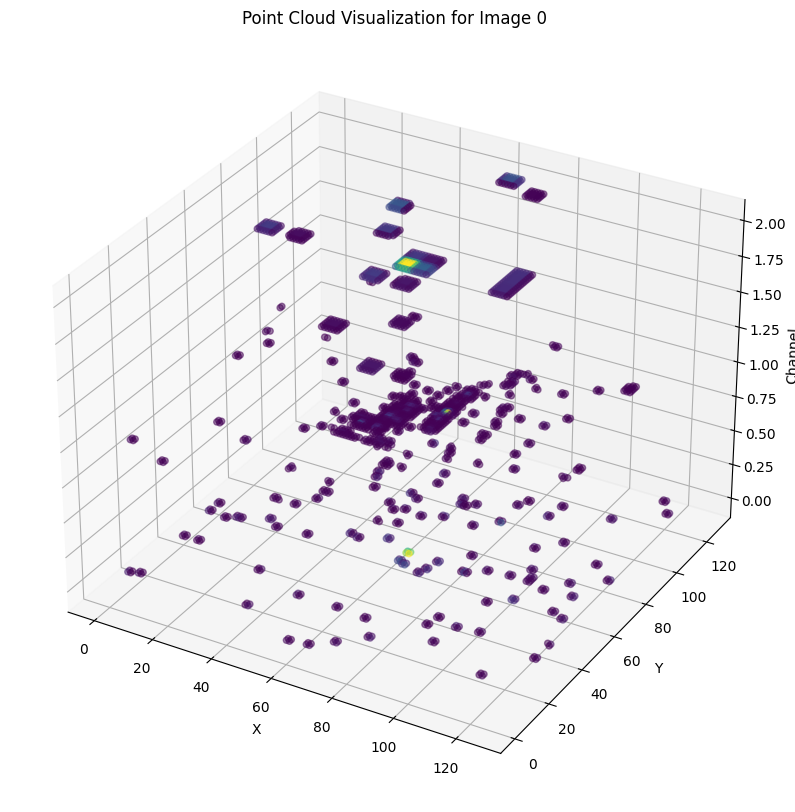

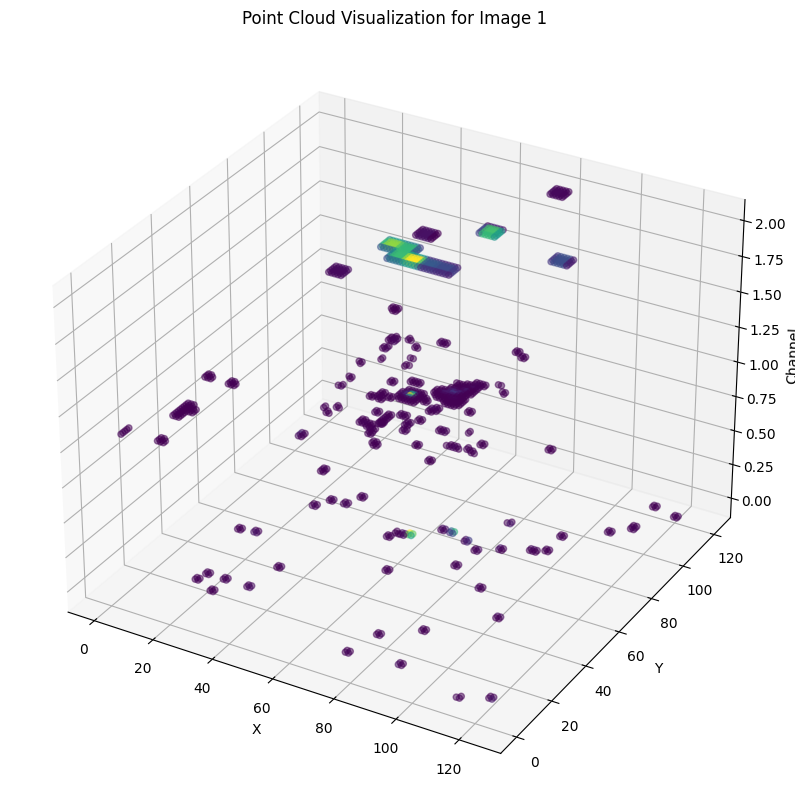

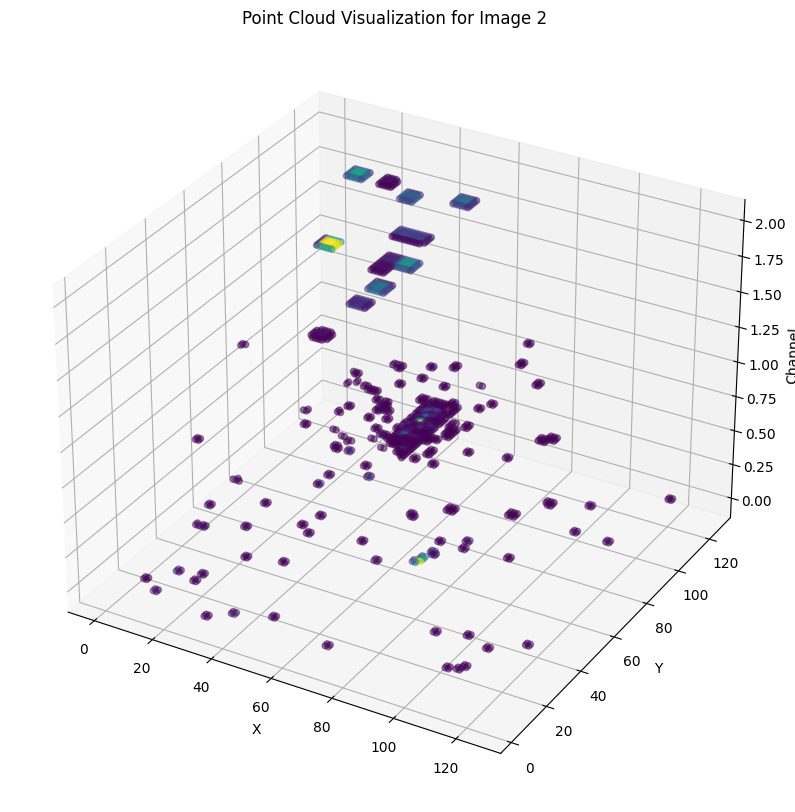

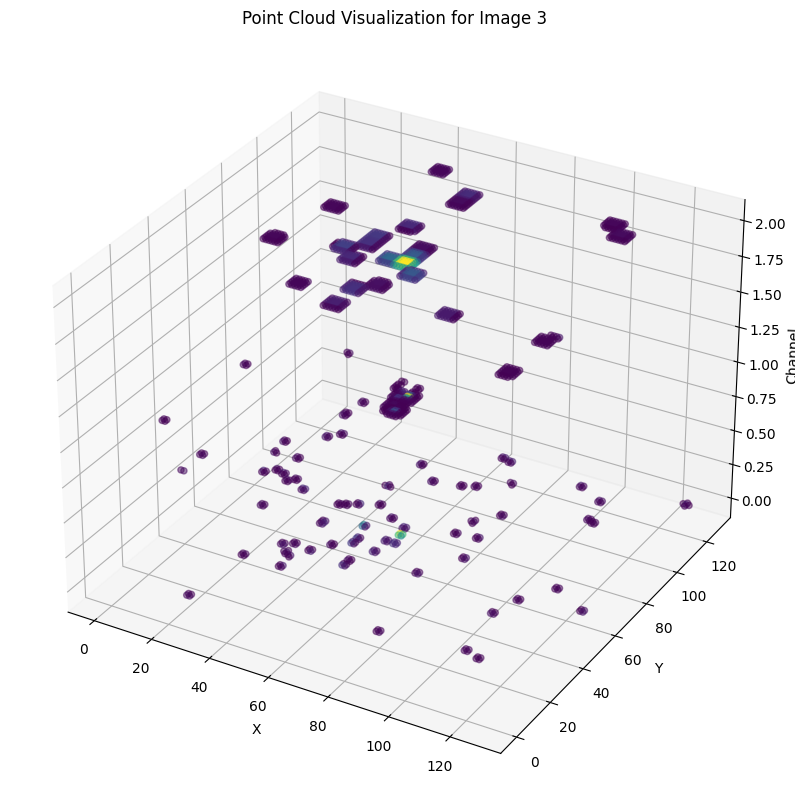

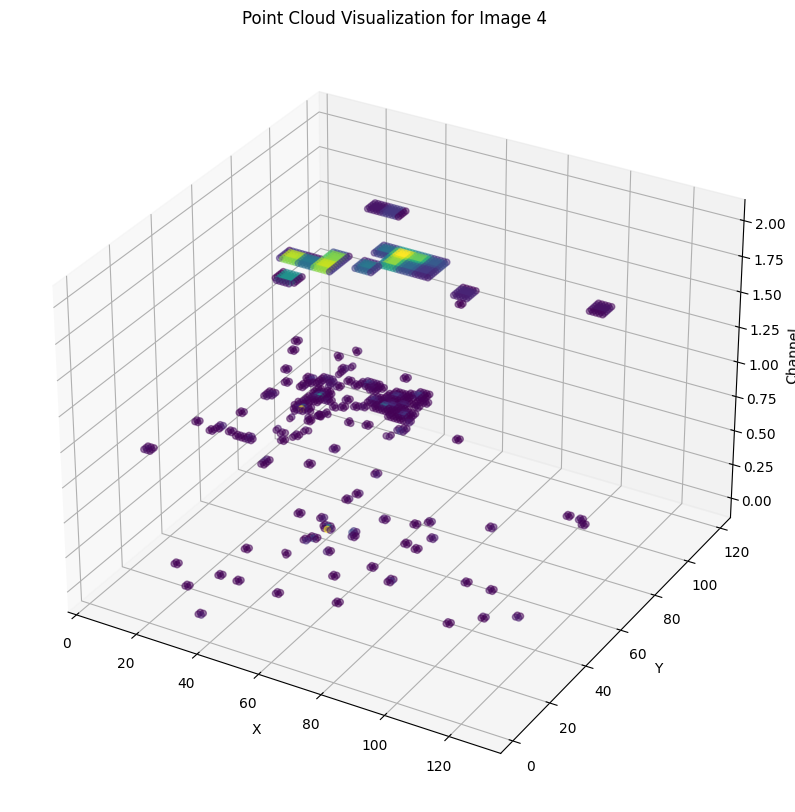

In [11]:
plot_point_clouds(X, y)

Now, the question comes -> how to suitably cast this point cloud data as a suitable graph data structure.

* We need a `node` construct, and an `edge` construct to atleast start off.
* Either make each pixel a `node`, or construct some cluster to acquire a node.
* Initially, we make each pixel a node, and invoke the `kneighbors_graph` function to construct the edges around these nodes, joining `n=2` nearest neighbors with each node.

`dataset` entity contains a graph for each of the loaded images, which we further split and load in train, test and validation loaders.

Instead of working on individual points like PointNet, exploit local geometric structures by constructing a local neighborhood graph and applying convolution-like operations on the edges connecting neighboring pairs of points, in the spirit of GNNs.

This gives us the added advantage of exploiting the nonlocal information that diffuses through the point cloud's updated feature spaces in subsequent layers.

In [12]:
def return_nonzero(X):
    # Reshape the data to be compatible with torch_geometric
    orig_len = X.shape[1]
    orig_wid = X.shape[2]
    data = X.reshape((-1, orig_len* orig_wid, 3))

    #Making a bool array to find which indices have non-zero values
    non_black_pixels_mask = np.any(data != [0., 0., 0.], axis=-1)

    mask_reshaped = non_black_pixels_mask.reshape((-1, orig_len, orig_wid))
    return mask_reshaped

In [13]:
mask_reshaped = return_nonzero(X)

In [14]:
def create_graph_feats(mask_reshaped):
    indices_list = []
    features_list = []
    for i, x in enumerate(mask_reshaped):
        true_indices = np.where(x)
        feature_vec = X[i, true_indices[0], true_indices[1], :]
        indices_array = np.column_stack((true_indices[0], true_indices[1]))
        indices_list.append(indices_array)
        features_list.append(feature_vec)
    return indices_list, features_list


In [15]:
indices_list, features_list = create_graph_feats(mask_reshaped)

In [ ]:
print(features_list[0].shape)

(1529, 3)


In [16]:
import argparse
import numpy as np
import scipy.sparse as sp


def import_class(name):
    try:
        components = name.split('.')
        module = __import__(components[0])
        for c in components[1:]:
            module = getattr(module, c)
    except AttributeError:
        module = None
    return module

def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')


def get_total_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {'Total': total, 'Trainable': trainable}


def _get_weights(dist, indices):
    num_nodes, k = dist.shape
    assert num_nodes, k == indices.shape
    assert dist.min() >= 0
    # weight matrix
    sigma2 = np.mean(dist[:, -1])**2
    dist = np.exp(-dist**2 / sigma2)
    i = np.arange(0, num_nodes).repeat(k)
    j = indices.reshape(num_nodes * k)
    v = dist.reshape(num_nodes * k)
    weights = sp.coo_matrix((v, (i, j)), shape=(num_nodes, num_nodes))
    # no self-loop
    weights.setdiag(0)
    # undirected graph
    bigger = weights.T > weights
    weights = weights - weights.multiply(bigger) + weights.T.multiply(bigger)
    return weights


def _get_normalize_adj(dist, indices):
    adj = _get_weights(dist, indices)
    adj = sp.coo_matrix(adj)
    row_sum = np.array(adj.sum(1))
    row_sum_nonzero = np.where(row_sum != 0, row_sum, 1)  # Avoid division by zero
    d_inv = np.power(row_sum_nonzero, -0.5).flatten()
    d_inv[np.isinf(d_inv)] = 0.0
    d_mat_inv_sqrt = sp.diags(d_inv)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def build_graph(coordinates, k=4):
    """
    :param coordinates: positions for 3D point cloud (N * 3)
    :param k: number of nearest neighbors
    :return: adjacency matrix for 3D point cloud
    """
    from scipy.spatial import cKDTree
    tree = cKDTree(coordinates)
    dist, indices = tree.query(coordinates, k=k)
    return _get_normalize_adj(dist, indices)


In [17]:
def create_graph_dataset(indices_list, y, connectivity = 10):
    graph_dataset = []
    for i, points in enumerate(indices_list):
        c = build_graph(points, k=connectivity)
        #edge_index = build_graph(points, k = connectivity)
        edge_list = torch.from_numpy(np.vstack((c.row, c.col))).type(torch.long)
#        edge_index = torch.from_numpy(edge_index).type(torch.long)
        edge_weight = torch.from_numpy(c.data.reshape(-1, 1))
        labels = torch.tensor([int(y[i])], dtype=torch.long)

        # Convert COO matrix to tensor
    #    adj_tensor = torch.sparse_coo_tensor((c.row, c.col), c.data, c.shape).to_dense()
        data = Data(x=torch.from_numpy(features_list[i]), edge_index=edge_list, y=labels, edge_attr = edge_weight)
    # edge_attr=edge_weight
        graph_dataset.append(data)

    return graph_dataset


In [18]:
graph_dataset = create_graph_dataset(indices_list, y, connectivity = 8)

Having a scoop at the obtained list of `torch_geometric.data.data.Data` objects, with each Data object being populated with the features tensor as `data.x`, Adjacency list as `data.edge_index`, Edge Attributes, containing the distance metric as `data.edge_attr`, and the sparsely constructed adjacency matrix as `data.adj`.

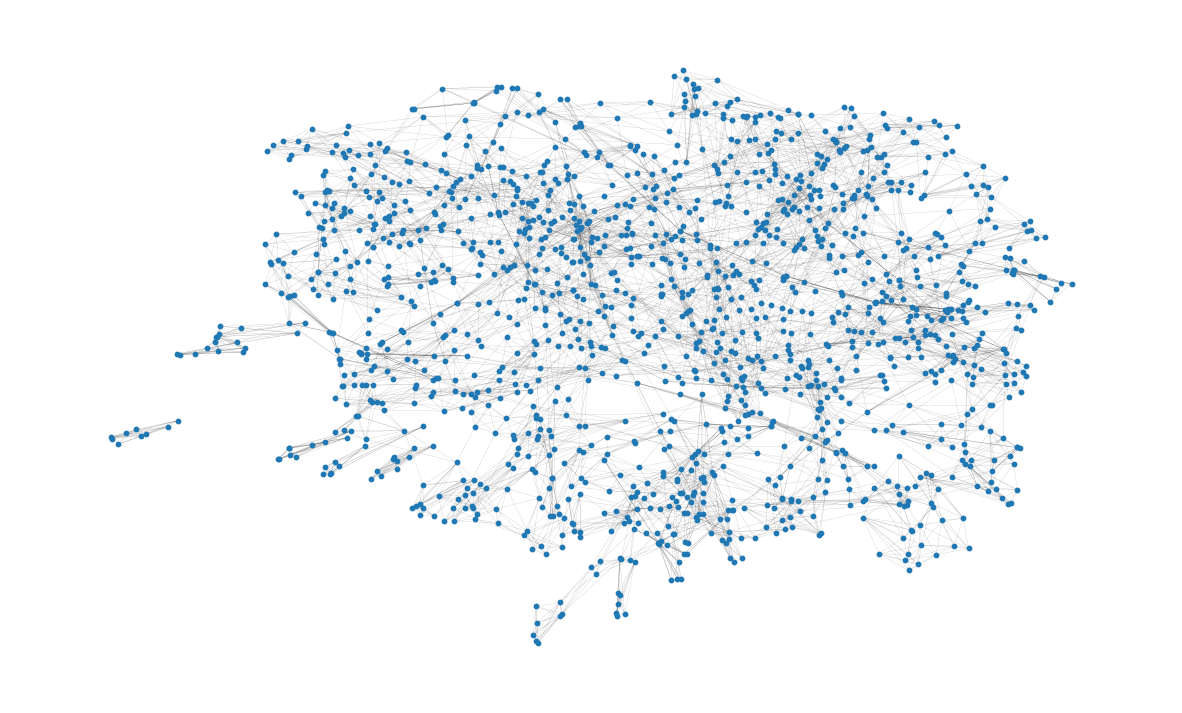

Number of graphs to work upon : 16000
For the FIRST graph in the  graph dataset : 
Type of each graph entity data object: <class 'torch_geometric.data.data.Data'>
Number of nodes: 1529
Number of edges: 12624
Number of node features: 3
Number of edges features: 1


In [19]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
data = graph_dataset[0]
edge_tensor = data.edge_index
# Convert the edge tensor to a list of tuples
edge_list = [(edge_tensor[0, i].item(), edge_tensor[1, i].item()) for i in range(edge_tensor.shape[1])]


#print(data.edge_index.shape)
G.add_edges_from(edge_list)
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_opt = {"node_size" : 10, "with_labels" : False, "width" : 0.05}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_opt)
plt.show()

print(f'Number of graphs to work upon : {len(graph_dataset)}')

print(f'For the FIRST graph in the  graph dataset : ')
print(f'Type of each graph entity data object: {type(data)}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of node features: {data.num_node_features}')
print(f'Number of edges features: {data.num_edge_features}')
#print(f'Number of edges features: {data.num_classes}')


## Defining a custom Graph Classification Scheme :


### Earlier Attempt :

GraphSAGE is one of the most popular GNN architectures, utilizing neighborhood aggregations via the use of a more expressive convolutional operator.

However, the resultant model could not exceed the baseline (51% accuracy), possibly due to the OVER-QUASHING PROBLEM and the shallowness of the jet image embeddings.

### Random Subset Conv :

I had earlier constructed a graph structure with high connectivity (8), hence I thought of using random neighborhood aggregation for message passing in the GNN, which is what I have implemented in the following :

In [20]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
class RandomSubsetConv(MessagePassing):
    def __init__(self, in_channels, out_channels, subset_size):
        super(RandomSubsetConv, self).__init__(aggr='add') # "add" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.subset_size = subset_size

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Sample a subset of neighbors for each node
        row, col = edge_index
        subset_indices = torch.randperm(row.size(0))[:self.subset_size]
        subset_edge_index = edge_index[:, subset_indices]

        # Step 3: Perform message passing
        return self.propagate(subset_edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j, edge_index, size):
        # x_j has shape [E, in_channels]
        # Step 4: Aggregate node features
        return self.lin(x_j)

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        # Step 5: Update node features
        return aggr_out


In [21]:
import torch
import torch.utils.data as data
from torchvision import transforms
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, TransformerConv, global_mean_pool
from torch_geometric.nn.norm import BatchNorm
import torch.nn as nn


class GraphSAGE(torch.nn.Module):
    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.3, dp_rate_dropout=0.5, subset_size=10):
        super().__init__()
        torch.manual_seed(17)

        self.conv1 = RandomSubsetConv(c_in, c_hidden, subset_size = 4)
        self.norm1 = nn.BatchNorm1d(c_hidden)
#        self.conv2 = RandomSubsetConv(c_hidden, 2 * c_hidden, subset_size = 4)
#        self.norm2 = nn.BatchNorm1d(2 * c_hidden)
        self.conv2 = RandomSubsetConv(c_hidden, c_hidden, subset_size = 4)
        self.norm2 = nn.BatchNorm1d(c_hidden)

        self.lin1 = nn.Linear(c_hidden, c_hidden // 2)
        self.lin2 = nn.Linear(c_hidden //2, c_out)

        self.dp_rate_linear = dp_rate_linear
        self.dp_rate_dropout = dp_rate_dropout
        self.dropout = nn.Dropout(dp_rate_dropout)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = x.relu()
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = x.relu()
        x = self.dropout(x)

 #       x = self.conv3(x, edge_index)
 #       x = self.norm3(x)
 #       x = x.relu()
 #       x = self.dropout(x)

        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)

        return x



In [22]:
class GraphLevelGNN(pl.LightningModule):
    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
 #       self.transform = transforms.Compose([transforms.ToTensor()])
        self.model = GraphSAGE(**model_kwargs)
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()

#    def __getitem__(self, data, index):
#       return self.transform(self.data.x[index]), self.transform(self.data.edge_index[index]), self.tranform(self.data.batch[index])

    def forward(self, data, mode="train"):
#        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        # print(data.x.shape, data.edge_index.shape, data.batch.shape)
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
#        print(x.shape)
#        print(edge_index.shape)
#        print(batch_idx.shape)
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)

        if self.hparams.c_out == 1:
            preds = (x > 0.7).float()
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)

        loss = self.loss_module(x, data.y)
        acc = (preds == data.y).sum().float() / preds.shape[0]

        return loss, acc

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.01, weight_decay=0.1)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="val")
        self.log('val_loss', loss, on_epoch=True, prog_bar=False)
        self.log('val_acc', acc, on_epoch=True, prog_bar=False)

    def test_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="test")
        self.log('test_loss', loss, on_epoch=True, prog_bar=False)
        self.log('test_acc', acc, on_epoch=True, prog_bar=False)

In [23]:
import torch


def train_graph_classifier(model_name, **model_kwargs):
    pl.seed_everything(17)

    trainer = pl.Trainer(max_epochs=50)

    # Check whether pretrained model exists. If yes, load it and skip training
    model = GraphLevelGNN(**model_kwargs)
    print(model)
    trainer.fit(model, train_loader, val_loader)
    model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    # train_result = trainer.test(model, dataloaders=train_loader, verbose=False)
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]['test_acc'], "valid": val_result[0]['test_acc']}
    return trainer, model, result


In [24]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
# Step 1: Data Splitting
train_dataset, test_dataset = train_test_split(graph_dataset, test_size=0.2, random_state=14)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=14)
# # Step 2: Define custom collate function
def collate(data_list):
    return Batch.from_data_list(data_list)

# Step 2: Data Loaders
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size= 128, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainer, model, result = train_graph_classifier("GraphSAGE", c_in=3, c_hidden = 64, c_out=2)


# THIS MODEL IS GIVING A VERY POOR SCORE. There is some intermittent issue in exceeding the baseline performance of error = 0.693

# Possibilities -> Cycles are being generated in the graph structures, which are deviating the learned representations to a certain constant vector embedding
# FOR THIS REASON, RATHER THAN CREATING A COMPLEX GRAPH CLASSIFICATON MODEL THAT MIGHT BE EXPERIENCING Over-Quashing problem, I create and train a very shallow neural network IN THE FOLLOWING SECTION :

INFO:lightning_fabric.utilities.seed:Seed set to 17
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


GraphLevelGNN(
  (model): GraphSAGE(
    (conv1): RandomSubsetConv()
    (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): RandomSubsetConv()
    (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (loss_module): CrossEntropyLoss()
)


INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GraphSAGE        | 6.8 K 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 134624. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 145512. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 138965. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 143549. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 138599. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 138737. To avoid any miscalculations, use `self.log(..., batch_size=batch_

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, num_in_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        # self.conv1 = RandomSubsetConv(num_in_features, hidden_channels, subset_size = 4)
        # self.conv2 = RandomSubsetConv(hidden_channels, 2*hidden_channels, subset_size = 4)
        # self.conv3 = RandomSubsetConv(2*hidden_channels, 4*hidden_channels, subset_size = 4)
        # self.conv4 = RandomSubsetConv(4*hidden_channels, 2*hidden_channels, subset_size = 4)
        # self.conv5 = RandomSubsetConv(2*hidden_channels, hidden_channels, subset_size = 4)
        self.conv1 = GCNConv(num_in_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2 * hidden_channels)
        self.conv3 = GCNConv(2 * hidden_channels, 4 * hidden_channels)
        self.conv4 = GCNConv(4 * hidden_channels, 2 * hidden_channels)
        self.conv5 = GCNConv(2 * hidden_channels, hidden_channels)
        self.lin = nn.Sequential(Linear(hidden_channels, hidden_channels//4, bias = False),
                                 nn.LeakyReLU(negative_slope= 0.2),
                                 Linear(hidden_channels//4, hidden_channels //8, bias = False),
                                 nn.LeakyReLU(negative_slope=0.2),
                                 Linear(hidden_channels//8, num_classes, bias = False),
                                 )


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = F.leaky_relu(self.conv1(x, edge_index), negative_slope=0.2)
#        x = x.relu()
        x = F.leaky_relu(self.conv2(x, edge_index), negative_slope=0.2)
#        x = x.relu()
        x = F.leaky_relu(self.conv3(x, edge_index), negative_slope= 0.2)

        x = F.leaky_relu(self.conv4(x, edge_index), negative_slope=0.2)
#        x = x.relu()
        x = F.leaky_relu(self.conv5(x, edge_index), negative_slope=0.2)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(num_in_features = 3, hidden_channels=64, num_classes = 2)
print(model)

GCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 128)
  (conv3): GCNConv(128, 256)
  (conv4): GCNConv(256, 128)
  (conv5): GCNConv(128, 64)
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=16, out_features=8, bias=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=8, out_features=2, bias=False)
  )
)


In [ ]:
import torch
from torch_geometric.data import DataLoader
from IPython.display import Javascript

# Assuming you've defined `GCN` class, `train_loader`, and `test_loader` DataLoader instances

# Set device to CUDA if available, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model and move it to the appropriate device
model = GCN(num_in_features=3, hidden_channels=64, num_classes=2).to(device)

# Move optimizer to the same device as the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:
        # Move data to the device
        data = data.to(device)

        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

# Training loop
for epoch in range(1, 40):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6391, Test Acc: 0.6488
Epoch: 002, Train Acc: 0.6843, Test Acc: 0.6800
Epoch: 003, Train Acc: 0.6974, Test Acc: 0.7003
Epoch: 004, Train Acc: 0.7102, Test Acc: 0.7100
Epoch: 005, Train Acc: 0.7095, Test Acc: 0.7134
Epoch: 006, Train Acc: 0.7118, Test Acc: 0.7172
Epoch: 007, Train Acc: 0.7140, Test Acc: 0.7191
Epoch: 008, Train Acc: 0.7157, Test Acc: 0.7172
Epoch: 009, Train Acc: 0.7138, Test Acc: 0.7178
Epoch: 010, Train Acc: 0.7168, Test Acc: 0.7172
Epoch: 011, Train Acc: 0.7178, Test Acc: 0.7200
Epoch: 012, Train Acc: 0.7162, Test Acc: 0.7209
Epoch: 013, Train Acc: 0.7172, Test Acc: 0.7203
Epoch: 014, Train Acc: 0.7174, Test Acc: 0.7197
Epoch: 015, Train Acc: 0.7173, Test Acc: 0.7188
Epoch: 016, Train Acc: 0.7179, Test Acc: 0.7197
Epoch: 017, Train Acc: 0.7184, Test Acc: 0.7194
Epoch: 018, Train Acc: 0.7188, Test Acc: 0.7225
Epoch: 019, Train Acc: 0.7188, Test Acc: 0.7212
Epoch: 020, Train Acc: 0.7191, Test Acc: 0.7191
Epoch: 021, Train Acc: 0.7171, Test Acc:

The following contains some other templates that I tried/wanted to try :
Similar results of

`Train_acc = 71 %`  & `Test_Acc = 69%` were achieved.

In [ ]:
import torch
import torch.nn as nn



class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.conv = nn.Conv1d(
            in_features, out_features, kernel_size=1, bias=bias
        )

    def forward(self, adj, x):

#        x = x.unsqueeze(0)  # Add a batch dimension at the beginning
#        adj = adj.unsqueeze(0)
        # print("Inside bmm", x.shape)
        # print("Inside bmm, adj", adj.shape)
#        x = torch.bmm(x, adj)
        x = self.conv(x)
        return x


class GlobalPooling(nn.Module):
    def __init__(self):
        super(GlobalPooling, self).__init__()
        self.max_pool = nn.AdaptiveMaxPool1d(output_size=1)
        self.avg_pool = nn.AdaptiveAvgPool1d(output_size=1)

    def forward(self, x):
        batch_size = x.size(0)
#        print('Batch Size', batch_size)
        x0 = self.max_pool(x).view(batch_size, -1)
#        x1 = self.avg_pool(x).view(batch_size, -1)
#        x = torch.cat((x0, x1), dim=-1)
        return torch.transpose(x0, 0, 1)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_mean_pool
from torch.nn import Linear
from collections import OrderedDict




class MultiLayerGCN(nn.Module):
    def __init__(self, dropout=0.5, num_classes=1):
        super(MultiLayerGCN, self).__init__()
        self.conv0 = GraphConvolution(3, 64, bias=False)
        self.conv1 = GraphConvolution(64, 64, bias=False)
        self.conv2 = GraphConvolution(64, 128, bias=False)
        self.conv3 = GraphConvolution(128, 256, bias=False)
        self.conv4 = GraphConvolution(256, 512, bias=False)
#        self.bn0 = nn.BatchNorm1d(64)
#        self.bn1 = nn.BatchNorm1d(64)
#        self.bn2 = nn.BatchNorm1d(128)
#        self.bn3 = nn.BatchNorm1d(256)
#        self.bn4 = nn.BatchNorm1d(1024)
        self.pool = GlobalPooling()
        # self.classifier = nn.Sequential(OrderedDict([
        #     ('fc0', nn.Linear(512, 256, bias=False)),
        #     ('relu0', nn.LeakyReLU(negative_slope=0.2)),
        #     ('bn0', nn.BatchNorm1d(256)),
        #     ('drop0', nn.Dropout(p=dropout)),
        #     ('fc1', nn.Linear(256, 128, bias=False)),
        #     ('relu1', nn.LeakyReLU(negative_slope=0.2)),
        #     ('bn1', nn.BatchNorm1d(128)),
        #     ('drop1', nn.Dropout(p=dropout)),
        #     ('fc2', nn.Linear(128, num_classes)),
        # ]))
        self.classifier = nn.Sequential(nn.Linear(512, 256, bias = False),
                                        nn.LeakyReLU(negative_slope=0.2),
                                        nn.Linear(256, 128, bias = False),
                                        nn.LeakyReLU(negative_slope=0.2),
                                        nn.Linear(128, 64, bias = False),
                                        nn.LeakyReLU(negative_slope = 0.2),
                                        nn.Linear(64, 2, bias = False))

    def forward(self, adj, x):
        # Convert the adjacency list to tensor
 #      adj_tensor = torch.stack(adj, dim=0)
#        print("Shape of x ", x.shape)
        x0 = F.leaky_relu(self.conv0(adj, x), negative_slope=0.2)
#        print("Shape of x0", x0.shape)
        x1 = F.leaky_relu(self.conv1(adj, x0), negative_slope=0.2)
#        print("Shape of x1", x1.shape)
        x2 = F.leaky_relu(self.conv2(adj, x1), negative_slope=0.2)
#        print("Shape of x2", x2.shape)
        x3 = F.leaky_relu(self.conv3(adj, x2), negative_slope=0.2)
        # x0 = F.leaky_relu(self.bn0(self.conv0(adj, x)), negative_slope=0.2)
        # x1 = F.leaky_relu(self.bn1(self.conv1(adj, x0)), negative_slope=0.2)
        # x2 = F.leaky_relu(self.bn2(self.conv2(adj, x1)), negative_slope=0.2)
        # x3 = F.leaky_relu(self.bn3(self.conv3(adj, x2)), negative_slope=0.2)
 #       x = torch.cat((x0, x1, x2, x3), dim=-1)
#        print("Shape of x3", x3.shape)
        x = F.leaky_relu(self.conv4(adj, x3), negative_slope=0.2)

 #       print("Again, shape of x", x.shape)
        x = self.pool(x)
 #       print("Shape of my heart", x.shape)
        x = self.classifier(x)
        return x

